In [1]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
import concurrent.futures

## Group Assignment
### Team Number: 2
### Team Member Names: Yiyun Jia, Tom Pan,  Victoria Zhao
### Team Strategy Chosen: RISKY

In [2]:
# Initiate a investment variable
investment_size = 100000

# Extract Tickers.csv into a dataframe
ticker_file = pd.read_csv('Tickers.csv')

In [3]:
# Change ticker_file into a list of tickers and also add the column name into that list since it can also be a stock name
ticker_list = list(ticker_file[ticker_file.columns[0]])
ticker_list.insert(0,ticker_file.columns[0])

# Removes the potential duplicates in ticker_list
ticker_list = list(pd.unique(ticker_list))

In [4]:
# Define a function to clean the data (change all tickers that do not exist or is not traded in the US market to None)
def clean(tic):
    if (yf.Ticker(tic).info['regularMarketPrice'] == None):
        return
    elif (yf.Ticker(tic).info['market'] == 'us_market'):
        return tic
    else:
        return

# Run the function concurrently in mutilple threads to improve the efficiency
with concurrent.futures.ThreadPoolExecutor() as executor:
    temp_ticker_list=executor.map(clean, ticker_list)
    
# Delete all elements in temp_ticker_list that are None values
clean_ticker_list = []
for i in temp_ticker_list:
    if i == None:
        clean_ticker_list = clean_ticker_list
    else:
        clean_ticker_list.append(i)

In [5]:
# Initiate start and end dates of stock data to check for volume requirements
vol_start_date = '2021-07-02'
vol_end_date = '2021-10-22'

# Initiate start and end dates of stock data that is relevant to us
start_date = '2021-07-02'
end_date = '2021-11-27'

# Define a function that changes any ticker with a average trading volume of 10000 to None
def clean_vol(tick):
    check_end_date = yf.Ticker(tick).history(start=start_date, end=end_date)
    if yf.Ticker(tick).history(start=vol_start_date, end=vol_end_date)['Volume'].mean() >= 10000 & (len(check_end_date[check_end_date.index=='2021-11-26']) == 1):
        return tick
    else:
        return

# Run the function concurrently in multiple threads to improve the efficiency
with concurrent.futures.ThreadPoolExecutor() as executor:
    temp_ticker_list = executor.map(clean_vol, clean_ticker_list)
    
# Delete all elements in temp_ticker_list that are None values
final_ticker_list = []
for i in temp_ticker_list:
    if i == None:
        final_ticker_list = final_ticker_list
    else:
        final_ticker_list.append(i)

In [6]:
# Function hist collects the closing price for each stock in the given time interval and generates a list containing the stock's ticker and a dataframe that contains its closing prices
def hist(ticker):
    return [ticker, pd.DataFrame(yf.Ticker(ticker).history(start = start_date, end = end_date)['Close'])]

# Function daily_return generates a dataframe that contains the daily return of a stock
def daily_return(df):
    daily = df.pct_change()
    daily.columns = ['daily_return']
    return daily

# Function std_return generates a list containing the stock's ticker and the standard deviation of its daily return
def std_return(ticker):
    return [ticker, daily_return(hist(ticker)[1])['daily_return'].std()]

# Function highest_std_return generates a list containing the ticker of the stock with highest std, it's std value, a name list that ranks the std of the stocks in descending order, 
# and a value list that ranks the std of the stocks in descending order.
def highest_std_return(df):
    riskiest_return = []
    riskiest_return_name = []
    for i in df.columns:
        if len(riskiest_return) == 0:
            riskiest_return_name.append(i)
            riskiest_return.append(df[i][0])
        for k in range(len(riskiest_return)+1):
            if k == len(riskiest_return):
                riskiest_return_name.append(i)
                riskiest_return.append(df[i][0])
                break
            elif df[i][0] > riskiest_return[k]:
                riskiest_return_name.insert(k, i)
                riskiest_return.insert(k, df[i][0])
                break
            else:
                continue
    return [riskiest_return_name[0], riskiest_return[0], riskiest_return_name, riskiest_return]

# Function daily_return_with_ticker generates a list that contains the stock's ticker and the daily return of that stock.
def daily_return_with_ticker(ticker):
    return [ticker, daily_return(hist(ticker)[1])[1:]]

# Function compare_corr compares the correlation between two stocks and inserts them into high_corr and high_corr_name following the ranking scheme
def compare_corr(df, lst1, lst2):
    for i in range(1, len(df.columns)):
        if len(lst1) == 0:
            lst1.append(df.iloc[i, 0])
            lst2.append(df.columns[i])
        else:
            for k in range(len(lst1)+1):
                if k == len(lst1):
                    lst1.append(df.iloc[i, 0])
                    lst2.append(df.columns[i])
                    break
                elif df.iloc[i, 0] > lst1[k]:
                    continue
                elif df.iloc[i, 0] < lst1[k]:
                    lst1.insert(k, df.iloc[i, 0])
                    lst2.insert(k, df.columns[i])
                    break
                else:
                    continue
    return lst1, lst2

In [7]:
# funciton portfolio_value_std consumes the name of the riskiest stock, the std of the riskiest stock, the cleaned ticker list, the std of the highest std portfolio, the daily price of all of the stocks, the daily return (pct_change) of all of the stocks
# function portfolio_value_std generates a list that contains:
#   a list of tickers without the ticker with the highest std, 
#   a portfolio with 10 selected stocks after using the algorithm
#   the std of the portfolio in the given interval
def portfolio_value_std(riskiest_stock, ticker_std, final_ticker_list, std_value, daily_price_df, daily_return_df):
    
    # Base Case: if the highest std of remaining ticker is less than the previous portfolio's std, then end the recursion
    if ticker_std < std_value:
        return None
    
    # Create a dataframe that accumulates the daily return of all the stocks in final_ticker_list, with the initial value of the daily return of the riskiest stock
    corr_df = daily_return_df[riskiest_stock]
    # Formatting
    corr_df.columns = [riskiest_stock]
    # Create a list that accumulates the tickers in final_ticker_list in the order collowing corr_df, with the initial value of the ticker of riskiest stock
    corr_ticker_list = [riskiest_stock]
    
    # Remove the riskiest_stock from the final_ticker_list and store the remaining tickers in a new list called new_final_ticker_list
    new_final_ticker_list = final_ticker_list.copy()
    new_final_ticker_list.remove(riskiest_stock)
    
    # Run the function concurrently in multiple threads to improve the efficiency
    with concurrent.futures.ThreadPoolExecutor() as executor:
        temp_ticker_list2 = executor.map(daily_return_with_ticker, new_final_ticker_list)
    
    # Use the accumlaters to records the daily_return of each stock and store it in corr_df with columns of the tickers
    for i in temp_ticker_list2:
        i[1].columns = [i[0]]
        corr_ticker_list.append(i[1])
        corr_df = pd.concat([corr_df, i[1]], join='outer', axis=1)
    
    # Drop last row
    corr_df.drop(corr_df.tail(1).index,inplace=True) 
    
    # Calculate the correlation between each stock and the stock with the highest std
    corr = corr_df.corr()
    
    # high_corr is a list that ranks the stocks that best correlates the riskiest stock.
    # high_corr_name is a list that contains the stock names based on the ranking of high_corr
    high_corr = []
    high_corr_name = []
    compare_corr(corr, high_corr, high_corr_name)
    
    # Make a list of the ten highest correlated tickers to the riskiest ticker (including the riskiest ticker)
    final_10_tickers = list(reversed(high_corr_name[-9:]))
    final_10_tickers.insert(0,riskiest_stock)
    
    # Set a dictionary detailing the weighing of the 10 stocks
    f_portfolio_dict = {
        'Ticker': final_10_tickers,
        'Weight': [0.35, 0.25, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
    }

    # Change that dictionary to a dataframe for further manipulation
    portfolio = pd.DataFrame(f_portfolio_dict)
    portfolio['Shares'] = ""
    portfolio['Price'] = ""
    portfolio['Value'] = investment_size * portfolio['Weight']
    # Resets portfolio since portfolio index is set to 1 to 10 for output (delete if not needed)
    portfolio.reset_index(inplace=True)
    # Resets portfolio shares according to our weighing but for the closing price on start_date for comparison purposes
    for i in range(len(final_10_tickers)):
        portfolio.loc[i, 'Price'] = daily_price_df[final_10_tickers[i]][0]
        portfolio.loc[i, 'Shares'] = portfolio.loc[i, 'Value'] / portfolio.loc[i, 'Price']
    
    # Initiate a dataframe to see the value of the portfolio over time for comparison purposes
    portfolio_value = pd.DataFrame()

    # Calculate the value of the portfolio over time so we can compare standard deviations
    for i in range(len(final_10_tickers)):
        ticker_value = pd.DataFrame()
        ticker_value = pd.DataFrame(daily_price_df[final_10_tickers[i]])
        ticker_value.columns = ['Close']
        ticker_value['Shares'] = portfolio['Shares'][i]
        ticker_value['Portfolio_Value'] = ticker_value['Shares'] * ticker_value['Close']
        portfolio_value = pd.concat([portfolio_value, pd.DataFrame(ticker_value['Portfolio_Value'])], axis = 1)

    # Rename the columns and add a new column that sums the value of the portfolio over time so we can see the over risk of the portfolio
    portfolio_value.columns = final_10_tickers
    portfolio_value['Value'] = portfolio_value.sum(axis=1)

    # Drop the last column since yahoo finance has a bug of making the last row all NaN
    portfolio_value = portfolio_value[:-1]
    
    # Formatting
    FinalPortfolio = portfolio[['Ticker', 'Price', 'Shares', 'Value', 'Weight']]

    return [new_final_ticker_list, FinalPortfolio, portfolio_value['Value'].pct_change().std()]

In [8]:
# function FINAL_FUNC generates a list that contains the portfolio with the highest std and its std value
def FINAL_FUNC(lst):
    # Create a list named constant_dec_lst that stores the list of tickers without the one with the highest std
    constant_dec_lst = lst.copy()
    # Create a list named portfolio_std_lst that stores the result from calling function portfolio_value_std.
    portfolio_std_lst = []
    # Create a dictory named std_dict that stores the ticker and its std value within the time interval
    std_dict = {}
    
    # Run the function std_return concurrently in multiple threads to improve the efficiency
    with concurrent.futures.ThreadPoolExecutor() as executor:
        temp_ticker_list1 = executor.map(std_return, lst)
    
    # Store the ticker and its std value to std_dict.
    for i in temp_ticker_list1:
        std_dict[i[0]] = i[1]
    
    # Create a dataframe named std_df that stores all tickers' stds
    std_df = pd.DataFrame(std_dict, index=[0])
    
    # Create a list named riskiest_stock_list that stores the std value of all the stocks in descending order and 
    # another list named riskiest_stock_name_list that stores the tickers in the same order.
    riskiest_stock_list = highest_std_return(std_df)[-1]
    riskiest_stock_name_list = highest_std_return(std_df)[-2]
    
    # Create Daily Closing Price Dataframe
    price_list = []
    daily_price_df = pd.DataFrame()
    # Run the function hist concurrently in multiple threads to improve the efficiency 
    with concurrent.futures.ThreadPoolExecutor() as executor:
        temp_ticker_list2 = executor.map(hist, final_ticker_list)    
    # Store the closing prices of each stock in the list named price_list
    for i in temp_ticker_list2:
        i[1].columns = [i[0]]
        price_list.append(i[1])
    # Combine all the closing prices into one dataframe named daily_price_df
    for i in range(len(price_list)):
        daily_price_df = pd.concat([price_list[i], daily_price_df], join='outer', axis=1)
    # Delete the last row because there is a bug with pd.concat that the last row may return NaN value.
    daily_price_df = daily_price_df[:-1]
    
    # Create Daily Return Dataframe
    daily_return_df = daily_price_df.pct_change()[1:]
    
    # Run the recursion that generates a list that contains the portfolio with highest std value at the end of the list.
    for i in range(len(lst)):
        # Base Case: If the portfolio_std_lst doesn't have any value, add in the first portfolio with its std values and update the constant_dec_lst.
        if len(portfolio_std_lst) == 0:
            temp_portfolio_std = portfolio_value_std(riskiest_stock_name_list[i], riskiest_stock_list[i], final_ticker_list, 0, daily_price_df, daily_return_df)
            # If the function portfolio_value_std returns None, then the recursion is done, return the last value of the accumlator.
            if temp_portfolio_std == None:
                return portfolio_std_lst[-1]
            else:
                portfolio_std_lst.append(temp_portfolio_std[1:])
                constant_dec_lst = temp_portfolio_std[0]
        else:
            # Otherwise, run the following algorithm: 
            #   If the new portfolio's std value is higher than the ones in the accumulator, append it to the list and update the constant_dec_lst.
            #   Otherwise, keep the accumulator unchanged and update the constant_dec_lst.
            temp_portfolio_std = portfolio_value_std(riskiest_stock_name_list[i], riskiest_stock_list[i], final_ticker_list, portfolio_std_lst[-1][-1], daily_price_df, daily_return_df)
            # If the function portfolio_value_std returns None, then the recursion is done, return the last value of the accumulator.
            if temp_portfolio_std == None:
                return portfolio_std_lst[-1]
            elif temp_portfolio_std[-1] > portfolio_std_lst[-1][-1]:
                portfolio_std_lst.append(temp_portfolio_std[1:])
                constant_dec_lst = temp_portfolio_std[0]
            else:
                portfolio_std_lst = portfolio_std_lst
                constant_dec_lst = temp_portfolio_std[0]
    # Return the last (the portfolio with the highes std) value in portfolio_std_lst
    return portfolio_std_lst[-1]

In [9]:
# Store the result of FINAL_FUNC with the cleaned list in a variable named p
p = FINAL_FUNC(final_ticker_list)
p

[  Ticker       Price      Shares    Value  Weight
 0    SLB   32.645065  1072.13754  35000.0    0.35
 1    OXY   32.566921  767.650089  25000.0    0.25
 2    COP   61.901985   80.772854   5000.0    0.05
 3    KMI   18.005268  277.696504   5000.0    0.05
 4    CAT  215.408234    23.21174   5000.0    0.05
 5      C   69.385284   72.061389   5000.0    0.05
 6    JPM  155.095413    32.23822   5000.0    0.05
 7    BAC   40.940205  122.129336   5000.0    0.05
 8    USB   57.131699    87.51709   5000.0    0.05
 9    COF  156.222534   32.005626   5000.0    0.05,
 0.020123740415308643]

In [10]:
# Check that our portfolio weight adds up to 0
print(sum(p[0]['Weight']))

# Check that our portfolio value adds up to 100000
print(sum(p[0]['Price']*p[0]['Shares']))

1.0000000000000002
100000.0


In [11]:
# Make a copy of p[0](the dataframe) and store it in a variable named portfolio
portfolio = p[0].copy()
portfolio

,Ticker,Price,Shares,Value,Weight
0,SLB,32.645065,1072.13754,35000.0,0.35
1,OXY,32.566921,767.650089,25000.0,0.25
2,COP,61.901985,80.772854,5000.0,0.05
3,KMI,18.005268,277.696504,5000.0,0.05
4,CAT,215.408234,23.21174,5000.0,0.05
5,C,69.385284,72.061389,5000.0,0.05
6,JPM,155.095413,32.23822,5000.0,0.05
7,BAC,40.940205,122.129336,5000.0,0.05
8,USB,57.131699,87.51709,5000.0,0.05
9,COF,156.222534,32.005626,5000.0,0.05


In [12]:
# Store the ticker choices into a variable named final_10_tickers
final_10_tickers = portfolio['Ticker']

# Create two empty columns named Price and Shares that stores the last closing price and the shares that can be bought with that closing price respectively.
portfolio['Price'] = ""
portfolio['Shares'] = ""
# Create a column named Value to store the amount of money to invest into each stock
portfolio['Value'] = investment_size * portfolio['Weight']

# Add the closing prices and number of shares purchased to the dataframe
for i in range(len(final_10_tickers)):
    portfolio.loc[i, 'Price'] = hist(portfolio.iloc[i,0])[1].iloc[[-1]].iloc[0,0]
    portfolio.loc[i, 'Shares'] = (portfolio.loc[i, 'Value'])/(portfolio.loc[i, 'Price'])

# Formatting
portfolio.index = np.arange(1, len(portfolio)+1)
FinalPortfolio = portfolio[['Ticker', 'Price', 'Shares', 'Value', 'Weight']]

FinalPortfolio

,Ticker,Price,Shares,Value,Weight
1,SLB,31.41,1114.294816,35000.0,0.35
2,OXY,32.009998,781.005977,25000.0,0.25
3,COP,74.830002,66.818119,5000.0,0.05
4,KMI,16.52,302.66343,5000.0,0.05
5,CAT,207.070007,24.146423,5000.0,0.05
6,C,67.279999,74.316291,5000.0,0.05
7,JPM,166.960007,29.947292,5000.0,0.05
8,BAC,47.630001,104.975853,5000.0,0.05
9,USB,59.84,83.55615,5000.0,0.05
10,COF,155.860001,32.080072,5000.0,0.05


In [13]:
# Create Stocks dataframe
Stocks = FinalPortfolio[['Ticker', 'Shares']]
Stocks

,Ticker,Shares
1,SLB,1114.294816
2,OXY,781.005977
3,COP,66.818119
4,KMI,302.66343
5,CAT,24.146423
6,C,74.316291
7,JPM,29.947292
8,BAC,104.975853
9,USB,83.55615
10,COF,32.080072


In [14]:
# Outputs Stocks to a CSV file
Stocks.to_csv('Stocks_Group_02.csv')

## Our Strategy

First, we will discuss our strategy in choosing the stocks that form the riskiest portfolio.

The first few lines of code are pretty self-explanatory: they import the csv file provided, converts it to a list of potential stocks, and removes any stocks that do not exist or does not meet the requirement of minimum 10000 average daily volume in the given timeframe.

##### Algorithm for finding a portfolio

We analyzed each stock's history in the time between July 2nd and November 26th of 2021. The starting date was chosen to be July 2nd because we are interested in the short term volatility of the stocks as the portfolios are only tracked for a week for the competition. Thus, we needed a timeframe short enought to capture current information about the stocks (ie. maybe there is some bad press/new legislation that disturbed the stock price recently but the stock is normally quite stable - we are still interested in this stock since the portfolio is only tracked for a week) but long enough to contain sufficient information for a proer analysis. We thought that July 2nd, which was also the timeframe we started tracking the volume of the stocks, was a healthy medium that fulfilled our needs. November 26th is a much more self-explanatory choice: we want to get the latest data prior to generating the portfolio.

In our analysis of each stock, we chose to find the most volatile stock by finding the stock with the highest standard deviation, meaning that the stock will be more likely to move further away from its average rate of returns. This brings our portfolio the most possible individual risk a stock in the list can bring, which sets a foundation for our "riskiest portfolio".

Since we want the riskiest portfolio possible, then we want to preserve the risk of the riskiest stock as much as possible since the addition of any "non-1" correlated stock (which is every stock other than itself) will always diversified away some (may be very small or large) risk from the portfolio. Therefore, we will only choose 10 stocks (the minimum required) to form our portfolio so the riskiest stock's risk will be prioritized and preserved. In choosing the other 9 stocks, we decided to find the stocks that had the highest correlation with the riskiest stock since those stocks will most resemble the shape of the riskiest stock and thus preserve the risk of the riskiest stock. 

As mentioned before, our strategy depends on maximizing the singular risk of the riskiest stock and minimizing the effect of diversification from any other stock that is added to the portfolio since we believe that will produce the highest risk possible for our portfolio. Then naturally, we will weigh the stocks in a way that follows that principle, so our weighing is as follows. We will use 35% (the maximum for a single stock) of our portfolio on purchasing the riskiest stock, 25% (the maximum while allowing the rest of the stocks to have an minimum amount invested) on purchasing the stock that correlated the highest with the riskiest stock, and 5% on each of the other stocks. This allows us to maximize the risk of the portfolio by preserving the risk of riskiest stock (since the stock that is most correlated to the riskiest will preserve that risk the best) and minimizing the impact of diversification from the other stocks on our portfolio.

#### Recursion of algorithm to find the final portfolio

Notice in the algorithm discuss above that there is a chance of failure of that algorithm: if the stock with the highest standard deviation is poorly correlated with all of the other stocks, then there might exist another stock that still has a very high standard deviation and also is highly correlated with many other stocks, which can form a portfolio of 10 stocks that might beat the portfolio generated from the original algorithm in terms of risk. This is because a low correlation with the rest of the stocks in a portfolio can result in heavy diversification of risk, which, in turn, heavily lowers the standard deviation of the portfolio.

Our solution to this is to test all of the possible portfolios that could potentially beat the first one we generated. However, doing that could require a lot of computing resources and time, so we did it in a way that eliminates the need to go through every single possibility.

Since we know that the maximum standard deviation of a portfolio is the standard deviation of the riskiest stock in that portfolio and our previous algorithm involves finding a stock that has a high standard deviation and building a portfolio around that stock, then we can safely assume that any stock with a standard deviation lower than the standard deviation of the first portfolio we found cannot be used to generate a portfolio with a higher standard deviation. Also, note that the case of having a higher standard deviation stock in the 9 correlated stocks which could bring the standard deviation of newly generated portfolio higher than the stock it is built around is handled in the recursion: any stock that has a higher standard deviation and a high correlation with this stock is already considered before this stock.

Using this logic, we can recurse the algorithm. First, we find a portfolio using the algorithm. Then, we find the next riskiests (highest standard deviation) stock and find a portfolio using the algorithm on that stock. We then compare the standard deviation of both of these portfolios and keep whichever one is higher. Then we run this same loop with the highest standard deviation portfolio out of the two and the next riskiest stock in the list until there exists no stock with a higher standard deviation than the highest standard deviation portfolio we have found. We stop here and output that portfolio.

## Graphs and Proofs

To visualize and prove our strategy works, we will compare the ten stocks we chose with ten random stocks by graphing and calculating the standard deviation of the two portfolios. Note that we will use the same weighing strategy for consistency purposes.

### Random Portfolio vs Our Portfolio

#### Our Portfolio Code

In [15]:
# Resets portfolio since portfolio index is set to 1 to 10 for output (delete if not needed)
portfolio.reset_index(inplace=True)

In [16]:
# Resets portfolio shares according to our weighing but for the closing price on start_date for comparison purposes
for i in range(len(final_10_tickers)):
    portfolio.loc[i, 'Shares'] = portfolio.loc[i, 'Value'] / yf.Ticker(final_10_tickers[i]).history(start = start_date, end = end_date)['Close'][0]

In [17]:
# Initiate a dataframe to see the value of the portfolio over time for comparison purposes
portfolio_value = pd.DataFrame()

# Calculate the value of the portfolio over time so we can compare standard deviations
for i in range(len(final_10_tickers)):
    ticker_value = pd.DataFrame()
    ticker_value = pd.DataFrame(yf.Ticker(final_10_tickers[i]).history(start = start_date, end = end_date)['Close'])
    ticker_value.columns = ['Close']
    ticker_value['Shares'] = portfolio['Shares'][i]
    ticker_value['Portfolio_Value'] = ticker_value['Shares'] * ticker_value['Close']
    portfolio_value = pd.concat([portfolio_value, pd.DataFrame(ticker_value['Portfolio_Value'])], axis = 1)

# Rename the columns and add a new column that sums the value of the portfolio over time so we can see the over risk of the portfolio
portfolio_value.columns = final_10_tickers
portfolio_value['Value'] = portfolio_value.sum(axis=1)

# Drop the last column since yahoo finance has a bug of making the last row all NaN
portfolio_value = portfolio_value[:-1]
portfolio_value

Ticker,SLB,OXY,COP,KMI,CAT,C,JPM,BAC,USB,COF,Value
Date,,,,,,,,,,,
2021-07-02,35000.000000,25000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,100000.000000
2021-07-06,33270.812991,23411.602930,4803.187037,4964.997681,4902.645351,4843.771510,4916.041712,4868.772368,4864.512498,4939.644176,95785.988254
2021-07-07,32747.788894,22621.239073,4701.992034,4927.302021,4929.509781,4823.887994,4921.809921,4829.890417,4862.775804,4925.031744,94291.227683
2021-07-08,32587.680311,22759.360684,4717.928514,4892.299172,4870.270186,4738.673554,4836.890429,4712.029067,4780.267484,4843.075443,93738.474845
2021-07-09,33292.162165,23204.419048,4791.235216,5026.924942,4992.193451,4860.814838,4991.668415,4865.127738,4947.889500,5100.063488,96072.498802
...,...,...,...,...,...,...,...,...,...,...,...
2021-11-17,34372.730993,23612.916929,5813.222389,4584.769341,4711.518968,4817.303772,5302.220028,5680.235206,5191.513743,4863.254771,98949.686138
2021-11-18,34158.302667,23520.798274,5873.802029,4520.899272,4675.308709,4836.039887,5256.441815,5657.030799,5132.877453,4896.540896,98528.041802
2021-11-19,32217.732248,22353.971250,5622.598405,4487.575459,4652.561303,4780.552309,5187.774249,5544.672034,5040.109217,4843.091559,94730.638034


#### Random Portfolio Code

In [18]:
# Get the 10 random stocks we will be comparing
random_10_tickers = np.random.choice(final_ticker_list, 10, replace=False)

# Set a dictionary to weigh the 10 random stocks
random_portfolio_dict = {
    'Ticker': random_10_tickers,
    'Weight': [0.35, 0.25, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
}

# Change that dictionary to a dataframe for further manipulation
random_portfolio = pd.DataFrame(random_portfolio_dict)

# Calculate the amount of money to invest into each stock
random_portfolio['Value'] = investment_size * random_portfolio['Weight']

In [19]:
# Sets random portfolio shares according to our weighing but for the closing price on start_date for comparison purposes
random_portfolio['Shares'] = 0
for i in range(len(random_10_tickers)):
    random_portfolio.loc[i, 'Shares'] = random_portfolio.loc[i, 'Value'] / yf.Ticker(random_10_tickers[i]).history(start = start_date, end = end_date)['Close'][0]

In [20]:
# Initiate a dataframe to see the value of the portfolio over time for comparison purposes
random_portfolio_value = pd.DataFrame()

# Calculate the value of the portfolio over time so we can compare standard deviations
for i in range(len(random_10_tickers)):
    ticker_value = pd.DataFrame()
    ticker_value = pd.DataFrame(yf.Ticker(random_10_tickers[i]).history(start = start_date, end = end_date)['Close'])
    ticker_value.columns = ['Close']
    ticker_value['Shares'] = random_portfolio['Shares'][i]
    ticker_value['Portfolio_Value'] = ticker_value['Shares'] * ticker_value['Close']
    random_portfolio_value = pd.concat([random_portfolio_value, pd.DataFrame(ticker_value['Portfolio_Value'])], axis = 1)

# Rename the columns and add a new column that sums the value of the portfolio over time so we can see the over risk of the portfolio
random_portfolio_value.columns = random_10_tickers
random_portfolio_value['Value'] = random_portfolio_value.sum(axis=1)

# Drop the last column since yahoo finance has a bug of making the last row all NaN
random_portfolio_value = random_portfolio_value[:-1]
random_portfolio_value

,UPS,TGT,PM,TXN,CAT,NEE,UNP,UNH,T,CMCSA,Value
Date,,,,,,,,,,,
2021-07-02,35000.000000,25000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,100000.000000
2021-07-06,34960.289438,24885.431344,4917.747005,4973.726354,4902.645351,5057.215558,4979.752437,5010.993126,4964.078306,4956.163113,99608.042033
2021-07-07,35451.709234,25098.345677,4924.725944,4936.787583,4929.509781,5070.678682,5080.767135,5028.092714,4948.682801,5000.000000,100469.299552
2021-07-08,35089.350677,25202.773997,4903.788741,4896.727507,4870.270186,5057.215558,4858.045310,5007.206559,4908.619749,5005.157416,99799.155701
2021-07-09,35395.452818,25202.773997,4955.134730,4949.534243,4992.193451,5047.792252,4932.582610,5033.589090,4955.650559,4987.966358,100452.670107
...,...,...,...,...,...,...,...,...,...,...,...
2021-11-17,34572.825154,25908.536667,4723.096354,4958.827909,4711.518968,5935.758392,5360.318257,5502.807700,4464.552112,4618.360085,100756.601599
2021-11-18,34509.615755,25729.892307,4620.146411,5060.845095,4675.308709,5923.586600,5371.273775,5509.181237,4415.670072,4536.702806,100352.222765
2021-11-19,34847.274133,25592.080320,4562.110635,5105.052675,4652.561303,5971.597528,5395.196603,5393.106855,4368.598515,4461.922080,100349.500647


#### Graph and Analysis

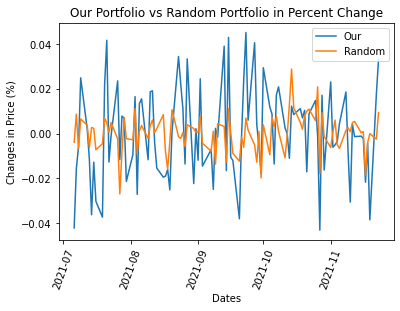

In [21]:
# Plot the data to visualize how risky each portfolio is
plt.plot(portfolio_value.index, portfolio_value['Value'].pct_change(), label='Our')
plt.plot(random_portfolio_value.index, random_portfolio_value['Value'].pct_change(), label='Random')

# Define labels
plt.title('Our Portfolio vs Random Portfolio in Percent Change')
plt.xlabel('Dates')
plt.xticks(rotation=70)
plt.ylabel('Changes in Price (%)')

# Create legend
plt.legend(loc='best')

plt.show()

In [22]:
print('The Standard Deviation for our Portfolio is:')
print(portfolio_value['Value'].pct_change().std())

print('')

print('The Standard Deviation for the Randomly Generated Portfolio is:')
print(random_portfolio_value['Value'].pct_change().std())

The Standard Deviation for our Portfolio is:
0.0202968086869566

The Standard Deviation for the Randomly Generated Portfolio is:
0.008411725470302122


Since our portfolio has a higher standard deviation - and we are confident that it will for any randomly generated portfolio - then our strategy is able to provide us with a riskier portfolio than just randomly picking ten stocks. This is also visualized by the graph, where we can clearly see that our portfolio fluctuates in percent change much more than the random portfolio, once again proving that our portfolio is more risky.

### Evenly Weighted vs Our Weighing

#### Evenly Weighted Portfolio Code

We will also compare the weighing of our ten stocks according to our strategy versus an even split in weighing amongst the stocks

In [23]:
# Set a dictionary to weigh the 10 stocks evenly
even_portfolio_dict = {
    'Ticker': final_10_tickers,
    'Weight': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
}

# Change that dictionary to a dataframe for further manipulation
even_portfolio = pd.DataFrame(even_portfolio_dict)

# Calculate the amount of money to invest into each stock
even_portfolio['Value'] = investment_size * even_portfolio['Weight']

In [24]:
# Sets random portfolio shares according to our weighing but for the closing price on start_date for comparison purposes
even_portfolio['Shares'] = 0
for i in range(len(final_10_tickers)):
    even_portfolio.loc[i, 'Shares'] = even_portfolio.loc[i, 'Value'] / yf.Ticker(final_10_tickers[i]).history(start = start_date, end = end_date)['Close'][0]

In [25]:
# Initiate a dataframe to see the value of the portfolio over time for comparison purposes
even_portfolio_value = pd.DataFrame()

# Calculate the value of the portfolio over time so we can compare standard deviations
for i in range(len(final_10_tickers)):
    ticker_value = pd.DataFrame()
    ticker_value = pd.DataFrame(yf.Ticker(final_10_tickers[i]).history(start = start_date, end = end_date)['Close'])
    ticker_value.columns = ['Close']
    ticker_value['Shares'] = even_portfolio['Shares'][i]
    ticker_value['Portfolio_Value'] = ticker_value['Shares'] * ticker_value['Close']
    even_portfolio_value = pd.concat([even_portfolio_value, pd.DataFrame(ticker_value['Portfolio_Value'])], axis = 1)

# Rename the columns and add a new column that sums the value of the portfolio over time so we can see the over risk of the portfolio
even_portfolio_value.columns = final_10_tickers
even_portfolio_value['Value'] = even_portfolio_value.sum(axis=1)

# Drop the last column since yahoo finance has a bug of making the last row all NaN
even_portfolio_value = even_portfolio_value[:-1]
even_portfolio_value

Ticker,SLB,OXY,COP,KMI,CAT,C,JPM,BAC,USB,COF,Value
Date,,,,,,,,,,,
2021-07-02,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,100000.000000
2021-07-06,9505.946569,9364.641172,9606.374075,9929.995362,9805.290701,9687.543021,9832.083423,9737.544736,9729.024997,9879.288351,97077.732407
2021-07-07,9356.511113,9048.495629,9403.984068,9854.604041,9859.019562,9647.775989,9843.619842,9659.780834,9725.551609,9850.063488,96249.406174
2021-07-08,9310.765803,9103.744274,9435.857029,9784.598344,9740.540373,9477.347108,9673.780857,9424.058134,9560.534969,9686.150886,95197.377776
2021-07-09,9512.046333,9281.767619,9582.470432,10053.849884,9984.386903,9721.629676,9983.336831,9730.255476,9895.778999,10200.126975,97945.649129
...,...,...,...,...,...,...,...,...,...,...,...
2021-11-17,9820.780284,9445.166771,11626.444778,9169.538682,9423.037936,9634.607544,10604.440055,11360.470411,10383.027486,9726.509543,101194.023489
2021-11-18,9759.515048,9408.319309,11747.604059,9041.798544,9350.617419,9672.079774,10512.883629,11314.061599,10265.754906,9793.081792,100865.716079
2021-11-19,9205.066357,8941.588500,11245.196809,8975.150917,9305.122606,9561.104619,10375.548499,11089.344068,10080.218435,9686.183118,98464.523928


#### Graph and Analysis

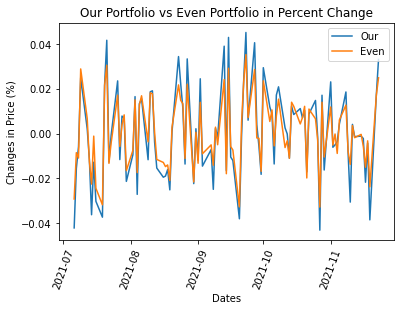

In [26]:
# Plot the data to visualize how risky each portfolio is
plt.plot(portfolio_value.index, portfolio_value['Value'].pct_change(), label='Our')
plt.plot(even_portfolio_value.index, even_portfolio_value['Value'].pct_change(), label='Even')

# Define labels
plt.title('Our Portfolio vs Even Portfolio in Percent Change')
plt.xlabel('Dates')
plt.xticks(rotation=70)
plt.ylabel('Changes in Price (%)')

# Create legend
plt.legend(loc='best')

plt.show()

In [27]:
print('The Standard Deviation for our Portfolio is:')
print(portfolio_value['Value'].pct_change().std())

print('')

print('The Standard Deviation for the Evenly Weighted Portfolio is:')
print(even_portfolio_value['Value'].pct_change().std())

The Standard Deviation for our Portfolio is:
0.0202968086869566

The Standard Deviation for the Evenly Weighted Portfolio is:
0.015589661787211499


As we can see from both the graph and the calculation, our weighing produces a portfolio with a higher standard deviation than one that is weighted evenly - and we are confident that it will always be the highest one out of any weighing combinations - which means our weighing strategy successfully gives a higher standard deviation.

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Yiyun Jia, Tom Pan,  Victoria Zhao